# 7. Data augmentation

Until now we have mostly played with synthetic data over which we have full control in terms of number of examples and content. Obviously that's not the case in the "real world" where you might mostly encounter two problems: 1. not enough training data and 2. inference data that are not exactly matching data used for training. This is where data augmentation can be useful.

Imagine for example that you trained an algorithm to detect objects in an image that always have the same orientation. However now for your inference the "alignment" of your acquisition system is drifting and objects are slightly rotated. This will make impact the quality of your inference. The way to go around this is to *artificially* create variations in your training set in the hope to achieve a more general results.

We are using again our simple example with geometric figures. However now for inference we will rotate the images and see how it impacts the result.

In [1]:
# set path containing data folder or use default for Colab (/gdrive/My Drive)
local_folder = "../"
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/guiwitz/DLImaging/master/utils/check_colab.py', 'check_colab.py')
from check_colab import set_datapath
colab, datapath = set_datapath(local_folder)

## Model and training

In [2]:
import torch
import torch.nn as nn
from torch.functional import F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

from skimage.draw import random_shapes
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# define network
class Mynetwork(nn.Module):
    def __init__(self, input_size, num_categories):
        super(Mynetwork, self).__init__()
        
        # define e.g. layers here e.g.
        self.layer1 = nn.Linear(input_size, 100)
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, num_categories)

    def forward(self, x):
        
        # flatten the input
        x = x.flatten(start_dim=1)
        # define the sequence of operations in the network including e.g. activations
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        
        return x

# define loss   
criterion = nn.CrossEntropyLoss()

# define dataset
images = np.load(datapath.joinpath('data/triangle_circle.npy'))
labels = np.load(datapath.joinpath('data/triangle_circle_label.npy'))

class Tricircle(Dataset):
    def __init__(self, data, labels, transform=None):
        super(Tricircle, self).__init__()
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        
        x = self.data[index]
        x = torch.tensor(x/255, dtype=torch.float32)
        y = torch.tensor(self.labels[index])
        
        return x, y

    def __len__(self):

        return len(labels)
    
tridata = Tricircle(images, labels)

batch_size = 10
test_size = int(0.8 * len(tridata))
valid_size = len(tridata)-test_size
train_data, valid_data = random_split(tridata, [test_size, valid_size])

train_loader = DataLoader(train_data, batch_size=batch_size)
valid_loader = DataLoader(valid_data, batch_size=batch_size)

## Train the model

In [14]:
num_classes = 2
model = Mynetwork(1024, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
for epoch in range(2):
    print(f'epoch: {epoch}')
    # initialize accuracy
    running_accuracy = 0
    
    for t, data in enumerate(train_loader):
    
        # get batch
        mybatch, label = data

        # calculate predicted label and calculate loss
        pred = model(mybatch)
        loss = criterion(pred, label)

        # backpropagate the loss
        loss.backward()

        # do the optimization step
        optimizer.step()

        # set gradients to zero as PyTorch accumulates them otherwise
        optimizer.zero_grad()

        # calculate accuracy
        mean_accuracy = (torch.argmax(pred,dim=1) == label).sum()/batch_size
        running_accuracy+=mean_accuracy

        every_nth = 1000
        if t % every_nth == every_nth-1: 
            print(f'accuracy: {running_accuracy/every_nth}')
            running_accuracy = 0.0
    
    # validation
    valid_accuracy=0
    for t, data in enumerate(valid_loader):
    
        # get batch
        mybatch, label = data

        # calculate predicted label
        pred = model(mybatch)
        # calculate accuracy
        mean_accuracy = (torch.argmax(pred,dim=1) == label).sum()/batch_size
        valid_accuracy+=mean_accuracy
    valid_accuracy = valid_accuracy/len(valid_loader)
    print(f'valid_accuracy: {valid_accuracy}')

epoch: 0
accuracy: 0.9956005215644836
accuracy: 0.9963002800941467
accuracy: 0.9962005615234375
accuracy: 0.9953001141548157
valid_accuracy: 0.9877011179924011
epoch: 1
accuracy: 0.9963001608848572
accuracy: 0.9982001781463623
accuracy: 0.9964001178741455
accuracy: 0.9976000785827637
valid_accuracy: 0.9973002672195435


## Feeding rotated data

We can use the ```skimage.transform.rotate``` function to rotate some of our images.

In [17]:
import skimage.transform

In [18]:
image, _ = random_shapes((32,32),max_shapes=1, min_shapes=1, multichannel=False, shape='triangle',
                                min_size=8)
image = 255-image

In [19]:
image_rot = skimage.transform.rotate(image, 10, preserve_range=True)

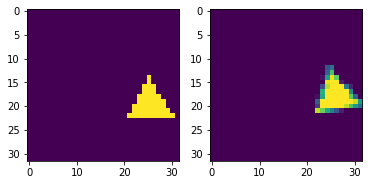

In [20]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(image_rot,)

We adjust our generating function (in [dlcourse.py](dlcourse.py) and create one that rotates objects randomly:

In [21]:
from dlcourse import make_image_rot

In [28]:
image_rot = make_image_rot('triangle', np.random.randint(0,10,1))

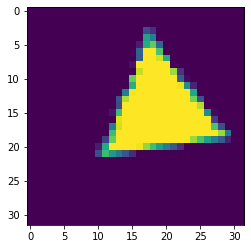

In [29]:
plt.imshow(image_rot)

Let's see how bad this is now:

In [30]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [33]:
im_type = ['triangle', 'circle']
label_test = torch.randint(0,len(im_type),(100,))
mybatch_test = torch.stack([make_image_rot(im_type[x], np.random.randint(0,90,1)) for x in label_test])
pred = model(mybatch_test)
accuracy = (torch.argmax(pred,dim=1) == label_test).sum()/100
print(f'accuracy: {accuracy}')

accuracy: 0.7599999904632568


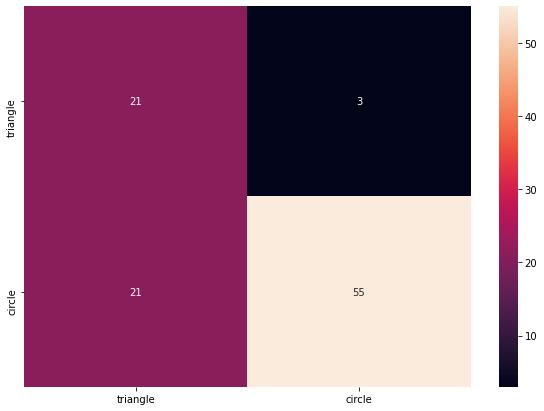

In [34]:
df_cm = pd.DataFrame(confusion_matrix(pred.argmax(dim=1), label_test), index = im_type,
                  columns = im_type)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True);

Obviously the problem only affects the triangle as the circle is rotationally invariant. So what can we do now? We can use data augmentation *during* training on our original *un-rotated* dataset. We will see later more general ways to do this but let's for the moment just rotate our data using functions from ```torchvision.transforms```:

In [35]:
import torchvision.transforms

In [36]:
rotation = torchvision.transforms.RandomRotation((0,40))

The nice thing with ```torchivision``` functions is that they accept batches by default. So we don't have to rotate each image individually:

In [72]:
iter_loader = iter(train_loader)

In [82]:
single_batch = next(iter_loader)
single_batch, single_label = single_batch

In [83]:
rotated_single_batch = rotation(single_batch)

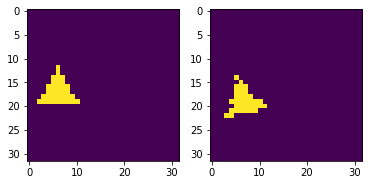

In [84]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(single_batch[2,:,:])
ax[1].imshow(rotated_single_batch[2,:,:])

In [87]:
model = Mynetwork(1024, len(im_type))
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    print(f'epoch: {epoch}')
    # initialize accuracy
    running_accuracy = 0
    
    for t, data in enumerate(train_loader):
    
        # get batch
        mybatch, label = data
        
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!Augmentation!!!!!!!!!!!!!!!!!!!!!!!
        mybatch = rotation(mybatch)
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!Augmentation!!!!!!!!!!!!!!!!!!!!!!!


        # calculate predicted label and calculate loss
        pred = model(mybatch)
        loss = criterion(pred, label)

        # backpropagate the loss
        loss.backward()

        # do the optimization step
        optimizer.step()

        # set gradients to zero as PyTorch accumulates them otherwise
        optimizer.zero_grad()

        # calculate accuracy
        mean_accuracy = (torch.argmax(pred,dim=1) == label).sum()/batch_size
        running_accuracy+=mean_accuracy

        every_nth = 1000
        if t % every_nth == every_nth-1: 
            print(f'accuracy: {running_accuracy/every_nth}')
            running_accuracy = 0.0
    
    # validation
    valid_accuracy=0
    for t, data in enumerate(valid_loader):
    
        # get batch
        mybatch, label = data

        # calculate predicted label
        pred = model(mybatch)
        # calculate accuracy
        mean_accuracy = (torch.argmax(pred,dim=1) == label).sum()/batch_size
        valid_accuracy+=mean_accuracy
    valid_accuracy = valid_accuracy/len(valid_loader)
    print(f'valid_accuracy: {valid_accuracy}')

epoch: 0
accuracy: 0.7698005437850952
accuracy: 0.8865019679069519
accuracy: 0.9390023350715637
accuracy: 0.9624016880989075
valid_accuracy: 0.9409025311470032
epoch: 1
accuracy: 0.9749013781547546
accuracy: 0.9795012474060059
accuracy: 0.9833015203475952
accuracy: 0.9885005950927734
valid_accuracy: 0.9738020896911621
epoch: 2
accuracy: 0.9878010749816895
accuracy: 0.9884010553359985
accuracy: 0.993100643157959
accuracy: 0.9924007654190063
valid_accuracy: 0.987900972366333
epoch: 3
accuracy: 0.9922006130218506
accuracy: 0.9935004115104675
accuracy: 0.9923005104064941
accuracy: 0.9944003224372864
valid_accuracy: 0.9867008924484253
epoch: 4
accuracy: 0.9933004379272461
accuracy: 0.9954003095626831
accuracy: 0.9947004914283752
accuracy: 0.9949002861976624
valid_accuracy: 0.9911008477210999


We see that we might need more epochs to achieve good training. This is expected as we now have "more" training data.

Let's see now if the network performs better on our directly generated rotated dataset:

In [88]:
pred = model(mybatch_test)
accuracy = (torch.argmax(pred,dim=1) == label_test).sum()/100
print(f'accuracy: {accuracy}')

accuracy: 0.8899999856948853


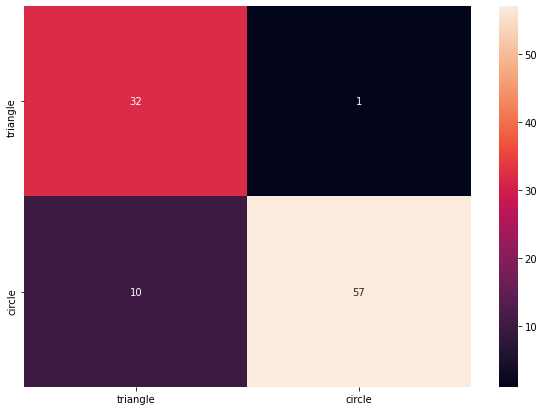

In [89]:
df_cm = pd.DataFrame(confusion_matrix(pred.argmax(dim=1), label_test), index = im_type,
                  columns = im_type)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True);

## Combine augmentation

It is very common to integrate the augmentation step in the data loading process. One can specify what modification one wants to apply randomly to the loaded images. For example here we combined rotation, and rotation transformations. This is done by *composing* (using ```Compose```) multiple augmentations in one module and passing it to the dataset. We see that we also integrate a stepf of conversion to tensor:

In [91]:
import torchvision.transforms

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((50,50)),
    torchvision.transforms.RandomRotation(20)
])

The expected input of ```transform``` is for example a Numpy array that should first be turned into a tensor, and then resized and rotated. We can see if that works with an image:

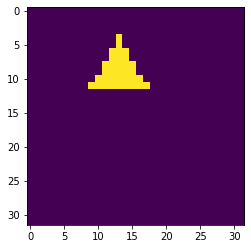

In [92]:
current_image = images[4,:,:]
plt.imshow(current_image)

In [93]:
tfmed = transforms(current_image)

In [94]:
tfmed.size()

torch.Size([1, 50, 50])

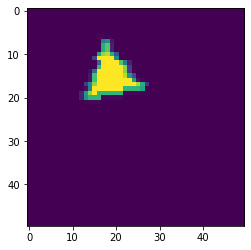

In [95]:
plt.imshow(tfmed[0,:,:])

Now we can pass our transform object when creating the dataset.

In [99]:
class Tricircle(Dataset):
    def __init__(self, data, labels, transform=None):
        super(Tricircle, self).__init__()
        self.data = data
        self.labels = labels
        self.transform = transform
        
    def __getitem__(self, index):
        
        x = self.data[index]
        if self.transform:
            x = self.transform(x)
        y = torch.tensor(self.labels[index])
        
        return x, y

    def __len__(self):

        return len(labels)
    
tridata = Tricircle(images, labels)

In [100]:
tridata = Tricircle(images, labels, transforms)

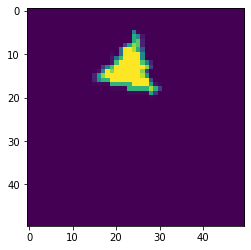

In [101]:
plt.imshow(tridata[4][0][0,:,:])